# Google cluster data trace

## Import headers

In [1]:
import graphlab
from pandas import read_csv
from os import listdir, chdir, path
from random import randint, sample, seed

## Change directory within the code

In [2]:
chdir('/Users/nmohan/Documents/Git Code/crowdsourced_cloud/clusterdata-2011-2')

In [3]:
print listdir('.')

['.DS_Store', 'job_events', 'machine_attributes', 'machine_events', 'MD5SUM', 'README', 'schema.csv', 'SHA1SUM', 'SHA256SUM', 'task_constraints', 'task_events', 'task_usage']


## Read the schema for organizing the trace

In [4]:
schema = graphlab.SFrame.read_csv("schema.csv")

This non-commercial license of GraphLab Create for academic use is assigned to nitinder.mohan@helsinki.fi and will expire on November 16, 2018.


[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: /tmp/graphlab_server_1516538127.log


Finished parsing file /Users/nmohan/Documents/Git Code/crowdsourced_cloud/clusterdata-2011-2/schema.csv

Parsing completed. Parsed 58 lines in 0.024252 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[str,int,str,str,str]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/nmohan/Documents/Git Code/crowdsourced_cloud/clusterdata-2011-2/schema.csv

Parsing completed. Parsed 58 lines in 0.009962 secs.

In [ ]:
schema.show()

## Figuring out task events

### Find the last timestamp for the trace

In [5]:
print sorted(listdir('task_events'))[-1]

part-00499-of-00500.csv.gz


In [6]:
task_events_csv_colnames = ['time', 'missing', 'job_id', 'task_idx', 'machine_id', 'event_type', 'user', 'sched_cls', 'priority', 'cpu_requested', 'mem_requested', 'disk', 'restriction']         

task_event_df = read_csv(path.join('task_events', 'part-00199-of-00500.csv.gz'), header=None, index_col=False, compression='gzip', names=task_events_csv_colnames)

In [ ]:
task_event_sf = graphlab.SFrame.read_csv(path.join('task_events', 'part-00199-of-00500.csv.gz'), header=None)
#task_event_sf.column_names
task_event_sf.rename({'X1':'time', 'X2':'missing', 'X3':'job_id', 'X4':'task_idx', 'X5':'machine_id', 'X6':'event_type', 'X7':'user', 'X8':'sched_cls', 'X9':'priority', 'X10':'cpu_requested', 'X11':'mem_requested', 'X12':'disk', 'X13':'restriction'})

In [ ]:
task_event_sf.show()

In [7]:
max_time = int(max(task_event_df['time']))
print max_time

1002839450969


## As the time is pretty huge, lets take a sample to collect the statistics and a single timestamp to collect all values

### Lets take 50 random values within 0 to max time

In [8]:
seed(90)
sample_moments = sorted(sample(xrange(max_time + 1), 200))
# if you take a larger sample, the statistics will take a longer time to finish

In [9]:
print(sample_moments)

[1966197554, 4953554963, 8028627094, 12788086239, 13982331234, 24779558087, 41160128117, 44051875508, 52767801425, 56096784752, 56428259365, 56780543600, 61175881749, 74490777767, 77470682027, 82272574746, 83301476663, 92956620274, 103111084642, 117891398973, 121782429549, 128828577215, 129201422557, 131829202299, 132194449867, 154415739335, 155424184792, 156318549782, 161638826179, 162439900251, 167679216941, 168647125622, 172965601406, 176471825043, 181164287927, 195638079323, 195660399350, 201813182944, 204248759670, 208486872476, 208563749581, 213417307756, 228180996518, 247048461916, 256151082999, 259313312052, 261694396392, 265478933436, 267597803503, 273604804262, 275853113007, 278997297018, 289347990703, 302002977840, 302543056039, 304593719216, 313499260301, 314377980496, 314995915521, 317768586836, 319646620979, 320342929494, 338506764219, 338708484100, 341000841605, 343426737983, 350465224304, 355854515945, 356712639220, 366358104649, 367965784646, 373256581766, 373714577884

### Take one random timestamp where we collect all values

In [10]:
snapshot_moment = randint(0, max_time)
print snapshot_moment

607132828776


### Let's add the statistics to a data frame

In [11]:
from collections import OrderedDict

from pandas import DataFrame

tasks_dict = {}
samples_dicts = OrderedDict([])
sample_moments_iterator = iter(sample_moments)
current_sample_moment = next(sample_moments_iterator)
count = 0
tasks_df = None

In [12]:
current_sample_moment

1966197554

In [13]:
#for fn in sorted(listdir('task_events')):    ## for every csv in task_events
    
#fp = path.join('task_events', fn)
fp = path.join('task_events', 'part-00199-of-00500.csv.gz')
task_events_df = read_csv(fp, header=None, index_col=False, compression='gzip', 
                              names=task_events_csv_colnames)

In [14]:
import numpy

for index, event in task_events_df.iterrows():
                    
        #only logging for certain events. We can skip this and log for all as well    
        if event['event_type'] in [0, 7, 8]:  #Update events on jobs (see documentation)
            #if numpy.isnan(event['disk']):
                tasks_dict[(event['job_id'], event['task_idx'])] = {'task_id' : (event['job_id'], event['task_idx']),
                                                                'time' : event['time'],
                                                                'machine_id' : event['machine_id'],
                                                                'cpu_requested' : event['cpu_requested'], 
                                                                'mem_requested' : event['mem_requested'],
                                                                'disk' : event['disk']}
                
                #tmp_tasks_df = DataFrame(tasks_dict.values())
                #samples_dicts[event['time']] = ({'time' : event['time'], 
                #                                 'cpu_requested' : sum(tmp_tasks_df['cpu_requested']), 
                #                                 'mem_requested' : sum(tmp_tasks_df['mem_requested']),
                #                                 'disk_requested' : sum(tmp_tasks_df['disk'])})

In [15]:
working_samples_df = DataFrame(tasks_dict.values())

## remove NaN entries for disk usage and time

In [16]:
samples_df = working_samples_df.copy(deep=True)
samples_df = samples_df.dropna(subset=['disk'])
samples_df = samples_df.dropna(subset=['time'])

## remove requests where CPU request is 0

In [17]:
samples_df = samples_df[samples_df.cpu_requested >= 0.001]

In [18]:
min(samples_df['cpu_requested'])

0.003124

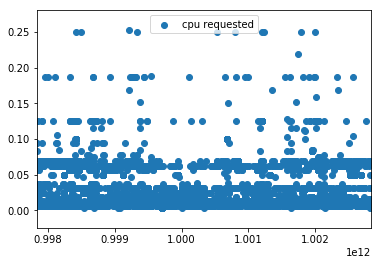

In [19]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(samples_df['time'], samples_df['cpu_requested'], label='cpu requested')
plt.xlim(min(samples_df['time']), max(samples_df['time']))
plt.legend()
plt.show()

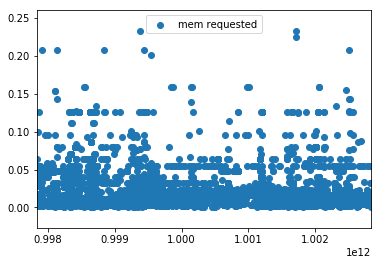

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(samples_df['time'], samples_df['mem_requested'], label='mem requested')
plt.xlim(min(samples_df['time']), max(samples_df['time']))
plt.legend()
plt.show()

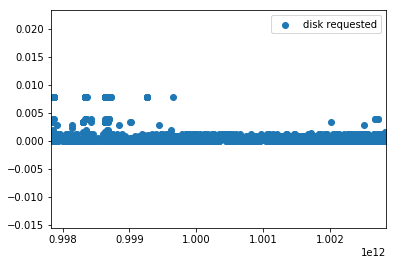

In [21]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(samples_df['time'], samples_df['disk'], label='disk requested')
plt.xlim(min(samples_df['time']), max(samples_df['time']))
plt.legend()
plt.show()

## Scaling CPU requests made by clients

In [22]:
new_sample_df = samples_df.copy(deep=True)

print new_sample_df

       cpu_requested      disk  machine_id  mem_requested  \
0           0.012500  0.000404         NaN       0.015900   
1           0.012500  0.000404         NaN       0.015900   
2           0.012500  0.000386         NaN       0.006104   
3           0.009369  0.000386         NaN       0.004929   
4           0.009369  0.000566         NaN       0.023320   
5           0.062500  0.001131         NaN       0.046630   
6           0.009369  0.001358         NaN       0.006218   
7           0.015960  0.000029         NaN       0.011660   
8           0.024990  0.000386         NaN       0.022340   
10          0.012500  0.000404         NaN       0.015900   
11          0.012500  0.000404         NaN       0.015900   
12          0.012500  0.000404         NaN       0.015900   
13          0.024990  0.000424         NaN       0.031800   
14          0.023470  0.000038         NaN       0.015900   
15          0.012500  0.000404         NaN       0.015900   
16          0.024990  0.

In [23]:
for index, event in new_sample_df.iterrows():
    
    if event['cpu_requested'] > 0 and event['cpu_requested'] <= 0.03:
        new_sample_df.loc[index, 'cpu_requested'] = event['cpu_requested'] * 90
        
    if event['cpu_requested'] > 0.03 and event['cpu_requested'] <= 0.08:
        new_sample_df.loc[index, 'cpu_requested'] = event['cpu_requested'] * 80
        
    if event['cpu_requested'] > 0.08:
        new_sample_df.loc[index, 'cpu_requested'] = event['cpu_requested'] * 60

In [24]:
min(new_sample_df['cpu_requested'])

0.28116000000000002

In [25]:
max(new_sample_df['cpu_requested'])

15.174000000000001

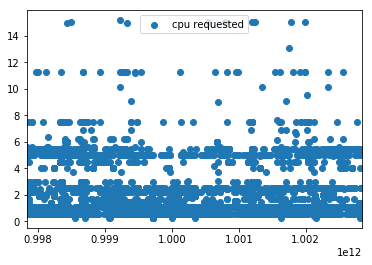

In [26]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(new_sample_df['time'], new_sample_df['cpu_requested'], label='cpu requested')
plt.xlim(min(new_sample_df['time']), max(new_sample_df['time']))
plt.legend()
plt.show()

## scaling the memory requests

In [27]:
for index, event in new_sample_df.iterrows():
    
    if event['mem_requested'] > 0 and event['mem_requested'] <= 0.0009:
        new_sample_df.loc[index, 'mem_requested'] = event['mem_requested'] * 350
        
    if event['mem_requested'] > 0.0009 and event['mem_requested'] <= 0.01:
        new_sample_df.loc[index, 'mem_requested'] = event['mem_requested'] * 330
        
    if event['mem_requested'] > 0.01:
        new_sample_df.loc[index, 'mem_requested'] = event['mem_requested'] * 310

In [28]:
min(new_sample_df['mem_requested'])

0.021696499999999997

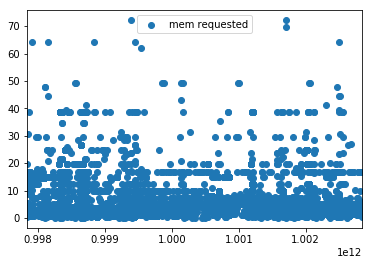

In [29]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(new_sample_df['time'], new_sample_df['mem_requested'], label='mem requested')
plt.xlim(min(new_sample_df['time']), max(new_sample_df['time']))
plt.legend()
plt.show()

## Add pricing model to requests

### Add a new column for prices

In [33]:
new_sample_df['price'] = numpy.nan

print new_sample_df

       cpu_requested      disk  machine_id  mem_requested  \
0            1.12500  0.000404         NaN        4.92900   
1            1.12500  0.000404         NaN        4.92900   
2            1.12500  0.000386         NaN        2.01432   
3            0.84321  0.000386         NaN        1.62657   
4            0.84321  0.000566         NaN        7.22920   
5            5.00000  0.001131         NaN       14.45530   
6            0.84321  0.001358         NaN        2.05194   
7            1.43640  0.000029         NaN        3.61460   
8            2.24910  0.000386         NaN        6.92540   
10           1.12500  0.000404         NaN        4.92900   
11           1.12500  0.000404         NaN        4.92900   
12           1.12500  0.000404         NaN        4.92900   
13           2.24910  0.000424         NaN        9.85800   
14           2.11230  0.000038         NaN        4.92900   
15           1.12500  0.000404         NaN        4.92900   
16           2.24910  0.

### We now add the pricing based on m4 frankfurt prices on AWS (https://aws.amazon.com/emr/pricing/) with a random coefficient from 0.5 to 2

In [35]:
import random

for index, event in new_sample_df.iterrows():
    price = 0
    coeff = random.uniform(0.5, 2)
    ## Less than 2core CPU and 8GB RAM
    if event['cpu_requested'] < 2 and event['mem_requested'] < 8:
        new_sample_df.loc[index, 'price'] = 0.12 * coeff
        continue
    ## Less than 4core CPU and 16GB RAM    
    elif event['cpu_requested'] < 4 and event['mem_requested'] < 16:
        new_sample_df.loc[index, 'price'] = 0.24 * coeff
        continue
    ## Less than 8core CPU and 32GB RAM    
    elif event['cpu_requested'] < 8 and event['mem_requested'] < 32:
        new_sample_df.loc[index, 'price'] = 0.48 * coeff
        continue
    ## All higher requests    
    else:
        new_sample_df.loc[index, 'price'] = 0.96 * coeff

In [36]:
print new_sample_df

       cpu_requested      disk  machine_id  mem_requested  \
0            1.12500  0.000404         NaN        4.92900   
1            1.12500  0.000404         NaN        4.92900   
2            1.12500  0.000386         NaN        2.01432   
3            0.84321  0.000386         NaN        1.62657   
4            0.84321  0.000566         NaN        7.22920   
5            5.00000  0.001131         NaN       14.45530   
6            0.84321  0.001358         NaN        2.05194   
7            1.43640  0.000029         NaN        3.61460   
8            2.24910  0.000386         NaN        6.92540   
10           1.12500  0.000404         NaN        4.92900   
11           1.12500  0.000404         NaN        4.92900   
12           1.12500  0.000404         NaN        4.92900   
13           2.24910  0.000424         NaN        9.85800   
14           2.11230  0.000038         NaN        4.92900   
15           1.12500  0.000404         NaN        4.92900   
16           2.24910  0.

## Save dataframe as CSV

In [37]:
new_sample_df.to_csv("google_cluster_pricing_dataset", sep='\t', index=False)